In [1]:
import pyaudi as pa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn 
seaborn.set_style("whitegrid")
from scipy.io import loadmat 

from Utils import draw 
from Utils import DA as da 
from Utils.RK4 import RK4
from Utils.submatrix import submatrices
from Utils.resample import resample 

In [10]:
from EntryGuidance import Unscented

In [51]:
# P0 = np.diag([1000, 100, 10, 10])
cxy = -150
cxu = -50
cyv = -15
cyu = 0
cxv = 0
cuv = -3
U = np.array([[0.5*1000, cxy, cxu, cxv],[0, 0.5*100, cyu, cyv],[0, 0, 0.5*10, cuv],[0, 0, 0,0.5*10]])
P0 = U + U.T
X,w,_ = Unscented.Transform(np.zeros((4,)), P0, 1)
print(X)
print(w)

[[  0.           0.           0.           0.        ]
 [ 70.71067812 -10.60660172  -3.53553391   0.        ]
 [  0.          19.68501969  -1.90500191  -3.81000381]
 [  0.           0.           5.81987695  -3.82449057]
 [  0.           0.           0.           4.5669621 ]
 [-70.71067812  10.60660172   3.53553391   0.        ]
 [  0.         -19.68501969   1.90500191   3.81000381]
 [  0.           0.          -5.81987695   3.82449057]
 [  0.           0.           0.          -4.5669621 ]]
[0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [75]:
P0

array([[1000., -150.,  -50.,    0.],
       [-150.,  100.,    0.,  -15.],
       [ -50.,    0.,   10.,   -3.],
       [   0.,  -15.,   -3.,   10.]])

In [125]:
data = loadmat(r"E:\Documents\GitHub\Research\Matlab\USRP_CL_unconstrained_small.mat")
told = data['time'].squeeze()
tnew = np.linspace(told[0], told[-1], 100)
data.keys()
data = {key: resample(told, val, tnew) for key,val in data.items() if key in ['state','mean','covariance','time', 'control']}

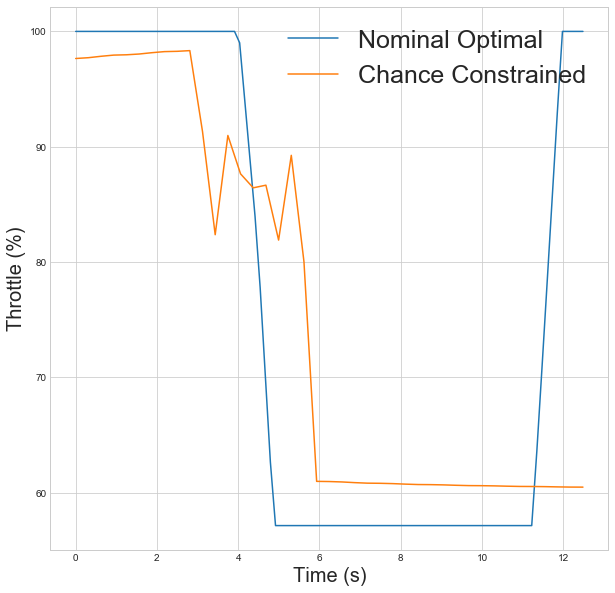

In [123]:
throttle = loadmat(r"E:\Documents\GitHub\Research\Matlab\throttle.mat")['throttle']
t = data['time'].squeeze()
ti = np.linspace(t[0], t[-1], throttle.size)
plt.figure(figsize=(10,10))
plt.plot(t, 100*data['control'][:,0]/np.max(data['control']), label="Nominal Optimal")
plt.plot(ti, 100*throttle, label="Chance Constrained")
plt.legend(fontsize=25, loc=1)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Throttle (%)', fontsize=20)
plt.savefig("./Documents/Qual/Control.png")

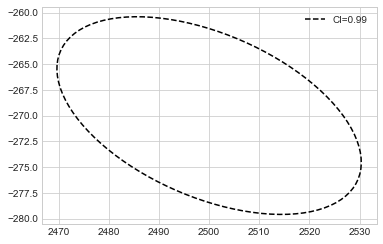

In [48]:
# cxy = -150
# draw.cov([-3000,2500], np.array([[1000, cxy], [cxy, 100]]))

# cxu = -50
# draw.cov([-3000, 625], np.array([[1000, cxu], [cxu, 10]]))

czv = -15
draw.cov([2500, -270], np.array([[100, czv], [czv, 10]]))

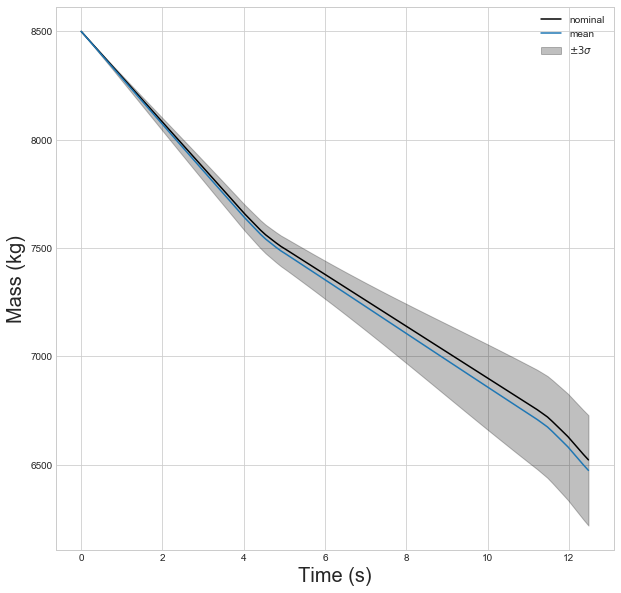

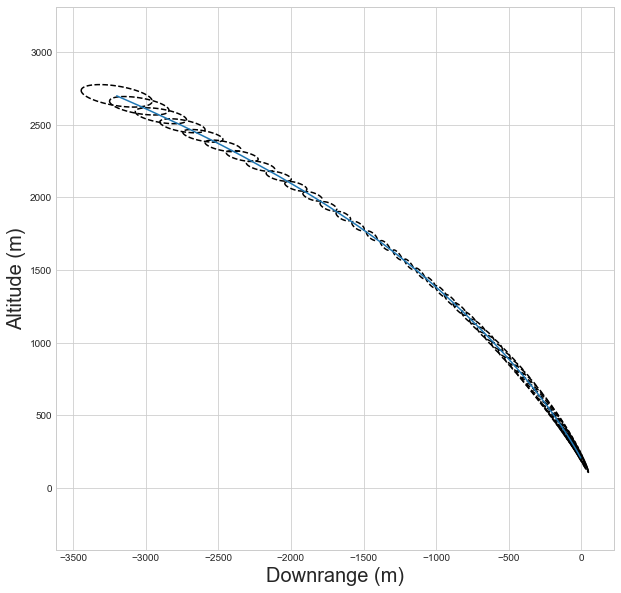

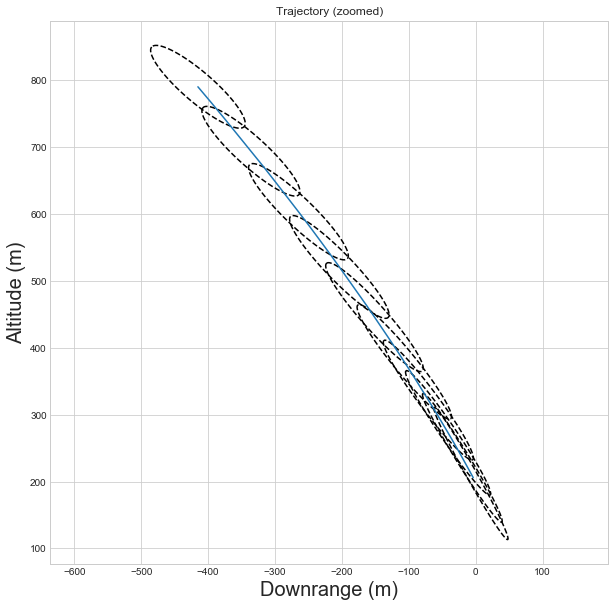

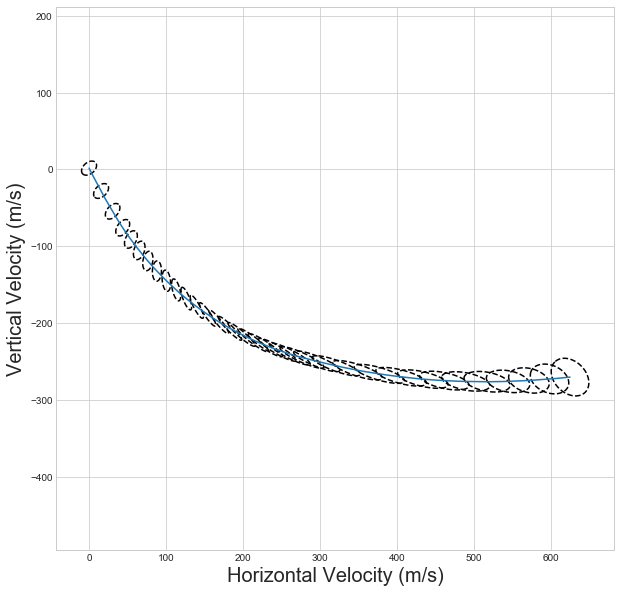

In [133]:
scale = (np.linspace(0.1,2,100))
P = data['covariance']/scale[:,None,None]
# x,y,u,v,m = data['state'][:,:5].T
x,y,u,v,m = data['mean'].T

plt.figure(1, figsize=(10,10))
plt.plot(t, data['state'][:,4],  'k', label="nominal")
draw.trajectory1d(t, m, data['covariance'][:,4,4]*scale, fill_kws={'alpha': 0.25, 'color': 'k', 'label': "$\pm 3\sigma$"})
plt.legend()
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel("Mass (kg)", fontsize=20)
plt.savefig("./Documents/Qual/Mass.png")

plt.figure(2, figsize=(10,10))
Pxy = submatrices(P, [0,1])
draw.trajectory2d(x, y+100, Pxy, fignum=2, downsample=2)
plt.xlabel('Downrange (m)', fontsize=20)
plt.ylabel("Altitude (m)", fontsize=20)
plt.axis('equal')

plt.savefig("Traj.png")

plt.figure(4, figsize=(10,10))
Pxy = submatrices(P, [0,1])
istart = 60
draw.trajectory2d(x[istart:], y[istart:]+100, Pxy[istart:], fignum=4, downsample=4)
# plt.plot(x[istart:], -x[istart:]*np.tan(np.radians(58)), 'r')
plt.title("Trajectory (zoomed)")
plt.xlabel('Downrange (m)', fontsize=20)
plt.ylabel("Altitude (m)", fontsize=20)
plt.axis('equal')

plt.savefig("TrajZoomed.png")

plt.figure(3, figsize=(10,10))
Puv = submatrices(P, [2,3])
draw.trajectory2d(u, v, Puv, fignum=3, downsample=3)
plt.xlabel('Horizontal Velocity (m/s)', fontsize=20)
plt.ylabel("Vertical Velocity (m/s)", fontsize=20)
plt.axis('equal')
plt.savefig("Velocity.png")

In [135]:
Puv[-1]

array([[15.90592887,  5.73140564],
       [ 5.73140564, 14.01392951]])

# Goal
Rewrite a differential equation with independent variable [0,1] and use tf as an expansion variable, in addition to initial conditions. Demonstrate that the expansion is accurate.

Define some nonlinear dynamics with a parameter to include in the expansion

In [2]:
def dyn(x, t, p, tf):
    dx1 = x[1]
    dx2 = -x[0] + p*(1-x[0]**2)*x[1]
    return np.array([dx1,dx2])*tf

Let's look at a few sample paths

(1000L, 2L, 50L)


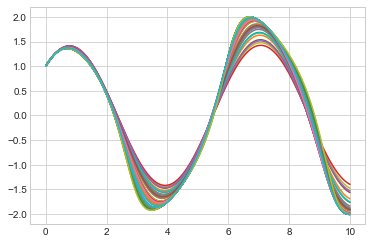

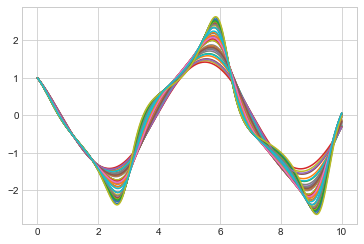

In [27]:
tf = 10
N = 50
x0 = 2*np.random.random((2,N))
x0 = np.ones_like(x0) # Deterministic ic
p = np.random.random((N,))

t = np.linspace(0,1,1000) # Idea - could we make the entire t array DA variables and expand that way? Then move the points optimally?!
x = RK4(dyn, x0, t, (p,tf))

print x.shape
for xi in np.transpose(x,(2,1,0)):
    plt.figure(1)
    plt.plot(t*tf, xi[0])
    plt.figure(2)
    plt.plot(t*tf, xi[1])
plt.show()

(1000L, 2L, 50L)


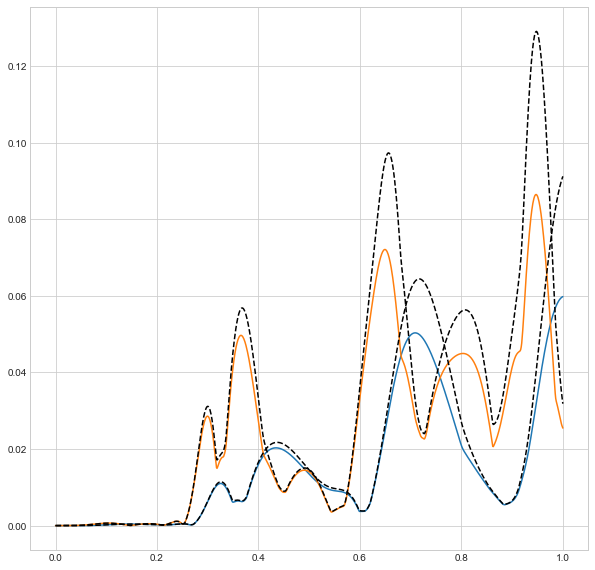

In [32]:
names = ['x','y','p','tf']
x0_nom = np.array([1,1])
p_nom = np.mean(p)
tf_nom = tf
x0_da = da.make([x0_nom[0],x0_nom[1],p_nom,tf_nom], names, 2)
x_da = RK4(dyn, x0_da[0:2], t, (x0_da[2], x0_da[3]))


delta = np.concatenate((x0.T-x0_nom, p[:,None]-p_nom, tf*np.ones_like(p[:,None])-tf_nom),axis=1)

# Verify we're evaluating at the correct points - these should match perfectly 
# print x0.T[0]
# print da.evaluate(x_da[0], names, delta[:1])[0]

x_eval = np.array([da.evaluate(x_da_i, names, delta).T for x_da_i in x_da])
print x_eval.shape

error = np.abs(x-x_eval)
err_mean = np.mean(error, axis=2)
err_var = np.std(error, axis=2)

plt.figure(1,figsize=(10,10))
plt.plot(t, err_mean)
plt.plot(t, err_mean+3*err_var, 'k--')
# plt.plot(t, err_mean-3*err_var, 'k--')

plt.show()

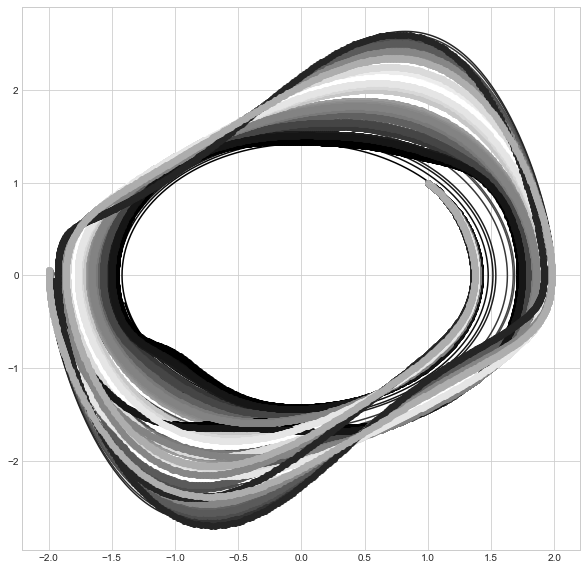

In [33]:
colors = np.linalg.norm(delta, axis=1)
colors = 1-(colors - colors.min())/(colors.max()-colors.min()) # Largest perturbations are black

# plot = plt.plot 
# for err,color in zip(np.transpose(error,(2,0,1)),colors):
#     plt.figure(1)
#     plot(t*tf, err[:,0], color='{}'.format(color))
#     plt.figure(2)
#     plot(t*tf, err[:,1], color='{}'.format(color))
plt.figure(figsize=(10,10))
for xi,color in zip(np.transpose(x,(2,1,0)),colors):
#     plt.plot(t*tf, xi.T)
    plt.plot(xi[0], xi[1],color='{}'.format(color))
    
for xi,color in zip(np.transpose(x_eval,(2,1,0)),colors):
    plt.plot(xi[0], xi[1], 'o--', color='{}'.format(color))    
    
plt.show()

# Next goal - Saturation
Determine how well DA can compensate with saturation via hyperbolic tangent. In the past it seem the error was acceptable.

In [28]:
def dyn_sat(x, t, tf=5):
    dx1 = x[1]
    dx2 = -x[0] + 1*(1-x[0]**2)*x[1]
#     dx2 = da.clip(dx2,-1,1)
    return np.array([dx1,dx2])*tf

In [41]:
N = 1000
x0 = (np.array([1, 1]) + np.random.normal(size=(N,2))/10).T
t = np.linspace(0, 1, 100)
x = RK4(dyn_sat, x0, t)

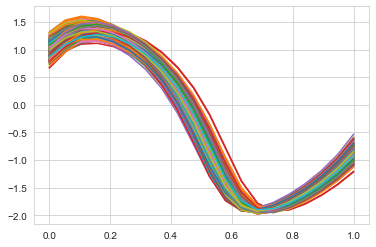

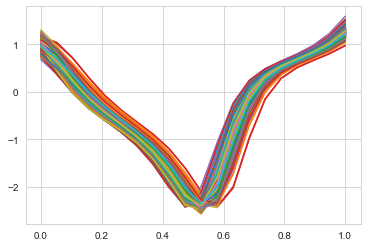

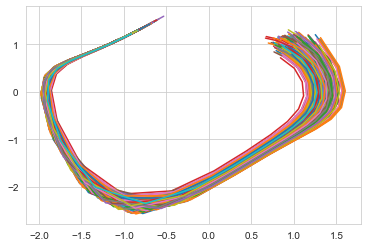

In [40]:
for xi in np.transpose(x,(2,1,0)):
    plt.figure(1)
    plt.plot(t, xi[0])
    plt.figure(2)
    plt.plot(t, xi[1])
    plt.figure(3)
    plt.plot(xi[0],xi[1])
plt.show()

(100, 2, 1000)


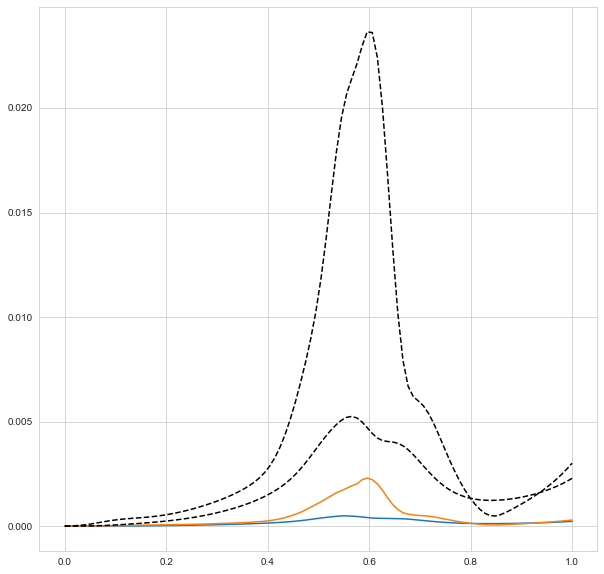

In [42]:
names = ['x','y']
x0_nom = np.array([1.,1.])
x0_da = da.make(x0_nom, names, 3)
x_da = RK4(dyn_sat, x0_da, t)


delta = x0.T-x0_nom

# Verify we're evaluating at the correct points - these should match perfectly 
# print x0.T[0]
# print da.evaluate(x_da[0], names, delta[:1])[0]

x_eval = np.array([da.evaluate(x_da_i, names, delta).T for x_da_i in x_da])
print(x_eval.shape)

error = np.abs(x-x_eval)
err_mean = np.mean(error, axis=2)
err_var = np.std(error, axis=2)

plt.figure(1, figsize=(10,10))
plt.plot(t, err_mean)
plt.plot(t, err_mean+3*err_var, 'k--')
plt.show()

In [48]:
C = [np.cov(e) for e in error]
C[50]

array([[1.45629792e-06, 2.70249964e-06],
       [2.70249964e-06, 1.26958607e-05]])

In [55]:
P0 = np.diag([1,1])/100
T = da.jacobian(x_da[50], names)
P = T.T.dot(P0).dot(T)
P

array([[ 0.0183125 , -0.01504852],
       [-0.01504852,  0.01675265]])

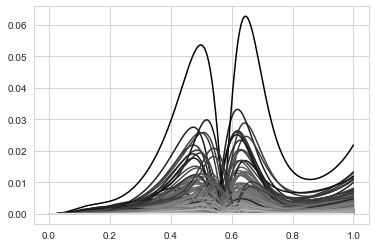

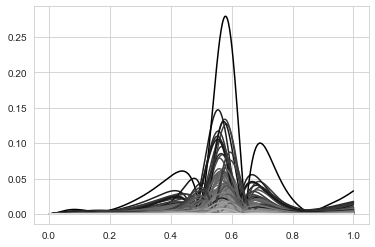

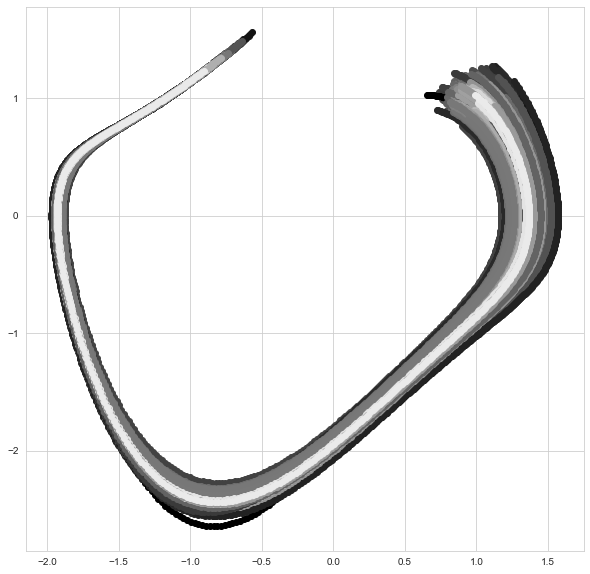

In [36]:
colors = np.linalg.norm(delta, axis=1)
colors = 1-(colors - colors.min())/(colors.max()-colors.min()) # Largest perturbations are black

tf = 1
plot = plt.plot 
for err,color in zip(np.transpose(error,(2,0,1)),colors):
    plt.figure(1)
    plot(t*tf, err[:,0], color='{}'.format(color))
    plt.figure(2)
    plot(t*tf, err[:,1], color='{}'.format(color))

plt.figure(figsize=(10,10))
for xi,color in zip(np.transpose(x,(2,1,0)),colors):
#     plt.plot(t*tf, xi.T)
    plt.plot(xi[0], xi[1],color='{}'.format(color))
    
for xi,color in zip(np.transpose(x_eval,(2,1,0)),colors):
    plt.plot(xi[0], xi[1], 'o', color='{}'.format(color))    
    
plt.show()

In [2]:
def dyn(x, t, p=1.):
    dx1 = x[1]
    dx2 = -x[0] + p*(1-x[0]**2)*x[1]
    return np.array([dx1,dx2])

In [4]:
x0 = np.array([1, 1.5])
t = np.linspace(0,3)

x = RK4(dyn, x0, t)

In [13]:
X0 = da.make(x0, 'xy', 2)
X = RK4(dyn, X0, t)
Xf = X[-1]

In [20]:
# print(da.jacobian(Xf, 'xy'))
STM = np.array([da.differentiate(xf, 'xy') for xf in Xf])
# print(STM)
P0 = np.diag([0.1, 0.1])
Pf = STM.dot(P0).dot(STM.T)
# print(Pf)
J = Pf[0,0] + Pf[1,1]
dJ = da.differentiate(J, 'xy')
# print(dJ)
print("J_x0 = {}".format(da.const(dJ)))
print("J_xx = {}".format(da.jacobian(dJ, 'xy')))

[[-0.96854536  0.93297133]
 [ 0.84079059 -1.1577459 ]]
J_x0 = [-0.1039099403909029, -1.0393677942675987]
J_xx = [[-2.94675942  0.50708338]
 [ 0.50708338  2.57435136]]


In [11]:
def dyn(x, t, a, u):
    return a*x + u - 0.5*x**3

a = 0.1
f1 = lambda x,t: dyn(x,t,a,-1)
f2 = lambda x,t: dyn(x,t,a,0)
f3 = lambda x,t: dyn(x,t,2*a,1)

def switched_dyn(x, t, f, s, *args):
    i = np.searchsorted(s, t, side='right') # Best solution, O(1), s must be sorted 
    return f[i](x, t, *args)

In [12]:
tf = 3
s = [1.5, 2.]

t = np.linspace(0, tf, 500)
x0 = [1]
x = RK4(switched_dyn, x0, t, ([f1,f2,f3], s))

0.100114+0.277305*dx0


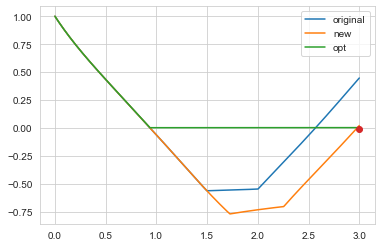

Original Cost:  0.10011430039634588
new Cost:       [0.00025002]
Estimated Cost: [-0.10571671]


In [19]:
# Compute the derivative wrt a switch
# Then show that x(new_time) = x(old_time) + dx/dti * (new_time-old_time)
# Confirmed - works perfectly when the dynamics are linear s

y0 = [pa.gdual_double(x0[0], 'x0', 1)]
y = RK4(switched_dyn, y0, t, ([f1,f2,f3], s))
J = (0.5 * y[-1]**2)[0]
print(J)
i = np.argmin(np.abs(t-s[0]))
j = np.argmin(np.abs(t-s[1]))

STMf = da.jacobian(y[-1], ['x0'])
STMi = da.jacobian(y[i], ['x0'])
STMj = da.jacobian(y[j], ['x0'])

STM1 = STMf/STMi
STM2 = STMf/STMj

alpha = 0.28  # Stepsize parameter since this is essentially gradient descent 
ds = -alpha*2*x[-1]*np.array([STM1*(f1(x[i], s[0]) - f2(x[i], s[0])), (STM2*(f2(x[j], s[1]) - f3(x[j], s[1])))]).squeeze()
# ds = np.array([0., -0.25])
xnew_stm = x[-1] + STM1*(f1(x[i], s[0]) - f2(x[i], s[0])) * ds[0] \
                 + STM2*(f2(x[j], s[1]) - f3(x[j], s[1])) * ds[1]
snew = s + ds 
xnew = RK4(switched_dyn, x0, t, ([f1,f2,f3], snew))
# xnm = RK4(switched_dyn, x0, t, ([f1,f2,f3], [1.72855037, 2.20861692])) # Using SLSQP or CG  method for linear dynamics
xnm = RK4(switched_dyn, x0, t, ([f1,f2,f3], [0.93639356, 2.99954693]))


plt.plot(t, x, label='original')
plt.plot(t, xnew, label='new')
plt.plot(t, xnm, label='opt')

plt.plot(tf, xnew_stm, 'o')
plt.legend()
plt.show()

# dJdx = da.gradient(J, ['x0'])/STMf
dJdx = x[-1]
print("Original Cost:  {}".format(J.constant_cf))
print("new Cost:       {}".format(0.5*xnew[-1]**2))
print("Estimated Cost: {}".format(J.constant_cf + dJdx*(xnew_stm-x[-1]) + 0*0.5*(xnew_stm-x[-1])**2))

In [17]:
def obj(s):
    tf = 3
    t = np.linspace(0, tf, 500)
    x0 = [1]
    y0 = [pa.gdual_double(x0[0], 'x0', 1)]
    y = RK4(switched_dyn, y0, t, ([f1,f2,f3], s)).squeeze()
    
    alpha = 1e-3
    J = 0.5*(y[-1].constant_cf)**2 + alpha*(s[0]-s[1])
    dJdx = y[-1].constant_cf #da.gradient(J, ['xf'])
    i = np.argmin(np.abs(t-s[0]))
    j = np.argmin(np.abs(t-s[1]))

    STMf = da.gradient(y[-1], ['x0'])
    STMi = da.gradient(y[i], ['x0'])
    STMj = da.gradient(y[j], ['x0'])

    STM1 = STMf/STMi
    STM2 = STMf/STMj
    dJds = alpha*np.array([1, -1])
    dxds =  np.array([STM1*(f1(x[i], s[0]) - f2(x[i], s[0])),  STM2*(f2(x[j], s[1]) - f3(x[j], s[1]))])
    return J, np.squeeze(dJdx*dxds)+dJds

J, dJds = obj([1.5, 2])

In [111]:
print(J)
print(dJds)
print(x[-1]*STM1*(f1(x[i], s[0]) - f2(x[i], s[0])),
                 x[-1]*STM2*(f2(x[j], s[1]) - f3(x[j], s[1])))

0.13637446123663036
[-0.67072142 -0.60721499]
[-0.67072142] [-0.60721499]


In [20]:
from scipy.optimize import minimize 
for method in ["SLSQP",]:
    sol = minimize(obj, s, jac=True, method=method)
    print(sol)
    print("\n")

# sol = minimize(obj, s, jac=True, method="trust-constr", hess="2-point")
# print(sol)


     fun: -0.002051834446948413
     jac: array([-0.00484793, -0.00597083])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.93639356, 2.99954693])




In [21]:
sol = minimize(lambda s: obj(s)[0], s, method=method) # without explicit jacobian provided 
print(sol)

In [23]:
sol = minimize(lambda s: obj(s)[0], s, method='Nelder-Mead') # without explicit jacobian provided 
print(sol)

 final_simplex: (array([[-1.00726846e+24,  6.27676424e+26],
       [-5.97381040e+23,  3.72256265e+26],
       [-3.54288971e+23,  2.20774146e+26]]), array([-6.28683693e+23, -3.72853646e+23, -2.21128435e+23]))
           fun: -6.286836926400023e+23
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 201
        status: 1
       success: False
             x: array([-1.00726846e+24,  6.27676424e+26])
